In [2]:
#Homemade Functions
from functions.functions_analysis import *
from functions.Path_combine_function import *
from functions.plot_functions import *
from functions.Preproc_functions import *
from functions.rotation_functions import *

#More nifti packages
from nilearn import plotting
import nibabel as nib


# Dipy
import dipy as dp
from dipy.io.image import load_nifti, save_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import dipy.data as dpd

#Preproc
from dipy.align import motion_correction
import dipy.direction.peaks as dpp
from dipy.viz import window, actor
from dipy.segment.mask import median_otsu
from dipy.core.histeq import histeq


#DIPY Plot
from dipy.viz import window, actor
from dipy.data import get_sphere

#Regular Packages
import keyboard  # For detecting keypresses
import IPython

import numpy as np
import os
import cv2

from pathlib import Path
from time import time
import time  # For simulating work
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import scipy.io
import pickle

import ants

c:\Users\Bruger\anaconda3\envs\DIPY\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



## Load in Data

In [ ]:
#Load in Data
DTI_combined , DTI_Affine_all = load_nifti("C:/DTI_SC/humanSC_400h/Combined_Data/Transposed/DTI_combined_preproc_trans_masked.nii.gz")

In [29]:
#Struc files
RARE_combined_masked, RARE_affine_all = load_nifti("C:/DTI_SC/humanSC_400h/Combined_Data/Transposed/RARE_combined_trans_masked.nii.gz")

#load Preproc structural data
RARE_combined_prepoc_masked, RARE_affine_all = load_nifti("C:/DTI_SC/humanSC_400h/Combined_Data/Transposed/RARE_combined_trans_denoised_gibbs_masked.nii.gz")

In [5]:
image = ants.image_read("190805-HumanSC/89-nii/RARE_2D_Ax.nii")

In [6]:
image.spacing

(0.05000000074505806, 0.05000000074505806, 0.20000000298023224)

## Find coordinates to calculate angle of rotation:

In [ ]:
### Draw Lines to get coordinates for commisural line running left-right in the SC (Method 2)
lines = []
drawing = False  # True when the mouse is pressed

for z in range(RARE_combined_masked.shape[2]):
    # Load image for slice z
    image = RARE_combined_masked[:, :, z]
    image_uint8 = ((image - np.min(image)) / (np.max(image) - np.min(image)) * 255).astype(np.uint8)

    # Resize for better visibility
    image_resized = cv2.resize(image_uint8, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)

    # Create window and set mouse callback
    cv2.namedWindow("Draw a Line", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Draw a Line", 800, 800)
    cv2.imshow("Draw a Line", image_resized)
    cv2.setMouseCallback("Draw a Line", draw_line)

    cv2.waitKey(0)  # Wait for user to draw the line
    cv2.destroyAllWindows()

# Print stored lines
print("\nAll Lines Drawn:")
for line in lines:
    print(f"Z={line[2]}: Start {line[0]} -> End {line[1]}")

# Convert lines to a structured NumPy array
lines_array = np.array(lines, dtype=[('start', '2i4'), ('end', '2i4'), ('z', 'i4')])

# Save lines using pickle
with open("C:/DTI_SC/humanSC_400h/Combined_Data/coordinates_of_lines_for_rotation.pkl", "wb") as f:
    pickle.dump(lines_array, f)


####### Compute the rotation angle for each line #########
# Create a new structured array with an additional field for the angle
new_dtype = np.dtype([('start', '2i4'), ('end', '2i4'), ('z', 'i4'), ('angle', 'f4')])
new_lines_array = np.zeros(len(lines_array), dtype=new_dtype)

for i in range(len(lines_array)):
    # Compute rotation angle using the i-th line
    angle = compute_rotation_angle_lines(lines_array[i])
    new_lines_array[i] = (lines_array[i][0], lines_array[i][1], lines_array[i][2], angle)

# Replace the old lines_array with the new one
lines_array = new_lines_array

## Use Gaussian Smoothing filter on rotation angle:

In [101]:
try:
    lines_array = np.load("C:/DTI_SC/humanSC_400h/Combined_Data/coordinates_of_lines_for_rotation.pkl", allow_pickle=True)
except:
    print("line array not yet written")

#####  Smooth the angles using Gaussian smoothing #######
from scipy.ndimage import gaussian_filter1d

#Change Start
mean_start = np.mean(lines_array["angle"][30:50]) 
sd_start = np.std(lines_array["angle"][30:50]) * 0.4
sample = np.random.normal(loc=mean_start, scale=sd_start, size=29)
slope_start = np.linspace(-5, -1, num=29)
lines_array["angle"][0:29] = sample + slope_start

# Change the end
n_samples = 1965-1831
end_mean = np.mean(lines_array["angle"][1810:1832])
end_std = np.std(lines_array["angle"][1810:1832]) * 0.3

sample = np.random.normal(loc=end_mean, scale=end_std, size=n_samples)

lines_array["angle"][1831:1965] = sample


# Extract the angles from the lines_array
angles = lines_array['angle']


# Apply Gaussian smoothing to the angles
smoothed_angles = gaussian_filter1d(angles, sigma=4)
print(smoothed_angles)

# Update the lines_array with the smoothed angles
lines_array_smoothed = lines_array.copy()
lines_array_smoothed['angle'] = smoothed_angles

# Create a new structured array with an additional field for the smoothed angle
new_dtype = np.dtype([('start', '2i4'), ('end', '2i4'), ('z', 'i4'), ('angle', 'f4'), ('smoothed_angle', 'f4')])
new_lines_array = np.zeros(len(lines_array), dtype=new_dtype)

for i in range(len(lines_array)):
    new_lines_array[i] = (lines_array[i][0], lines_array[i][1], lines_array[i][2], lines_array[i][3], smoothed_angles[i])

# Replace the old lines_array with the new one
lines_array = new_lines_array

# Verify the updated lines_array
print(lines_array[0])


# Save lines using pickle
with open("C:/DTI_SC/humanSC_400h/Combined_Data/coordinates_of_lines_for_rotation.pkl", "wb") as f:
    pickle.dump(new_lines_array, f)

[-27.924671 -27.91699  -27.900625 ...  31.629263  31.680965  31.709166]
([0, 0], [0, 0], 0, -27.585405, -27.924671)


## Generate a 0-value of rotation for those images that don't have an asscociated line drawn for them
Either because: 

    1. They were perfectly alligned already.
    2. The picture didnt complete the entire spinal cord making it hard to correct. (at the rostral and caudal end)

In [102]:
# Load lines_array from the saved .npy file
lines_array = np.load("C:/DTI_SC/humanSC_400h/Combined_Data/coordinates_of_lines_for_rotation.pkl", allow_pickle=True)

### The Z-indexes without a line drawn (either its angle is 0 or it was not drawn) will have a 0 value of rotation angle.
# Get the total number of slices in the z-axis
total_slices = RARE_combined_masked.shape[2]

# Create a new structured array with the same dtype as lines_array
complete_lines_array = np.zeros(total_slices, dtype=lines_array.dtype)

# Initialize the new array with default values
for z in range(total_slices):
    complete_lines_array[z] = ((0, 0), (0, 0), z, 0.0, 0.0)

# Copy existing values from lines_array to complete_lines_array
for line in lines_array:
    z = line['z']
    complete_lines_array[z] = line


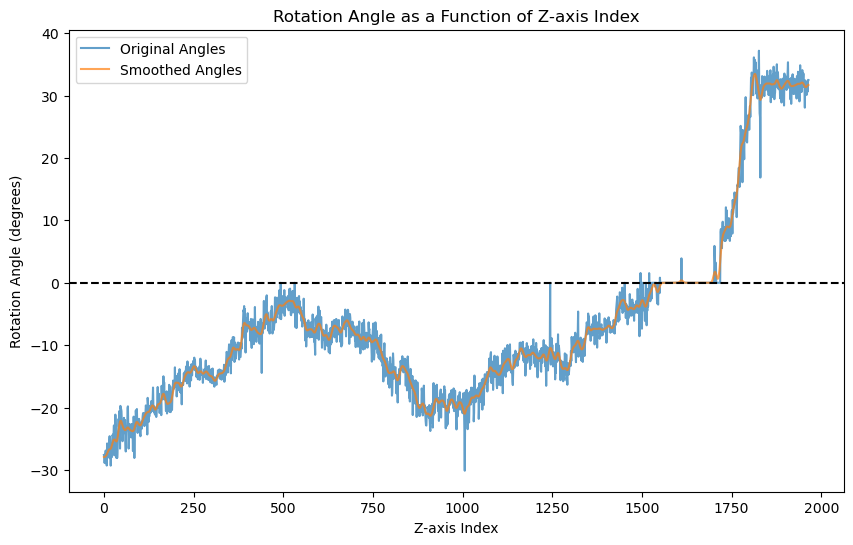

In [103]:
# Load lines_array from the saved .npy file
lines_array = np.load("C:/DTI_SC/humanSC_400h/Combined_Data/coordinates_of_lines_for_rotation.pkl", allow_pickle=True)

# Plot the rotation angle as a function of z-axis index
plt.figure(figsize=(10, 6))
plt.plot(complete_lines_array['z'], complete_lines_array["angle"], label='Original Angles', alpha=0.7)
plt.plot(complete_lines_array['z'], complete_lines_array["smoothed_angle"], label='Smoothed Angles', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Z-axis Index')
plt.ylabel('Rotation Angle (degrees)')
plt.title('Rotation Angle as a Function of Z-axis Index')
plt.legend()
plt.show()

In [104]:
# Find all indexes where the angle is equal to 0
zero_angle_indexes = np.where(complete_lines_array['angle'] == 0)[0]
print(zero_angle_indexes)

complete_lines_array["angle"][1528:1718] = 0
complete_lines_array["smoothed_angle"][1528:1718] = 0

[ 493  532 1244 1452 1502 1503 1511 1525 1528 1529 1530 1531 1532 1533
 1534 1535 1536 1537 1539 1540 1546 1551 1552 1553 1554 1555 1556 1557
 1558 1559 1560 1561 1562 1563 1564 1565 1566 1567 1568 1569 1570 1571
 1572 1573 1574 1575 1576 1577 1578 1579 1580 1581 1582 1583 1584 1585
 1586 1587 1588 1589 1590 1591 1592 1593 1594 1595 1596 1597 1598 1599
 1600 1601 1602 1603 1604 1605 1606 1607 1608 1609 1611 1612 1613 1614
 1615 1616 1617 1618 1619 1620 1621 1622 1623 1624 1625 1626 1627 1628
 1629 1630 1631 1632 1633 1634 1635 1636 1637 1638 1639 1640 1641 1642
 1643 1644 1645 1646 1647 1648 1649 1650 1651 1652 1653 1654 1655 1656
 1657 1658 1659 1660 1661 1662 1663 1664 1665 1666 1667 1668 1669 1670
 1671 1672 1673 1674 1675 1676 1677 1678 1679 1680 1681 1682 1683 1684
 1685 1686 1687 1688 1689 1690 1691 1692 1693 1694 1695 1696 1697 1698
 1699 1700 1701 1707 1708 1709 1710 1711 1712 1713 1714 1715 1716 1717
 1718]


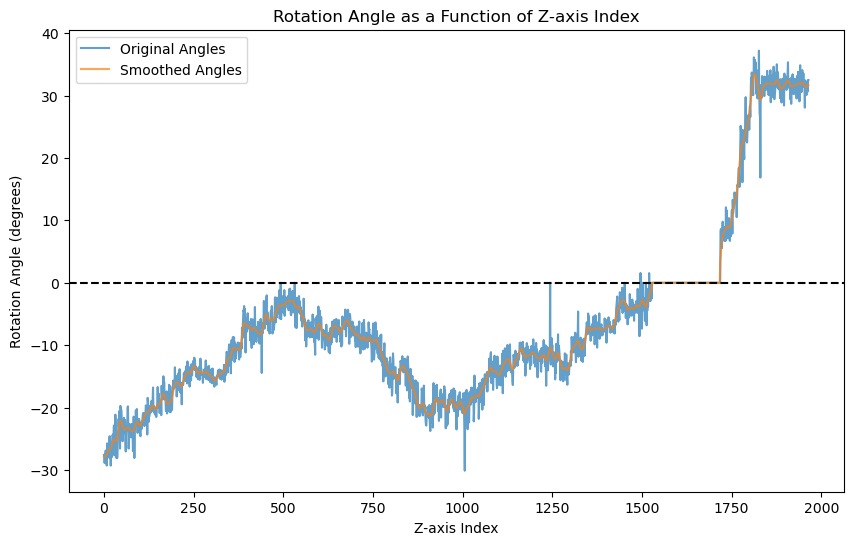

In [105]:
# Plot the rotation angle as a function of z-axis index.
plt.figure(figsize=(10, 6))
plt.plot(complete_lines_array['z'], complete_lines_array["angle"], label='Original Angles', alpha=0.7)
plt.plot(complete_lines_array['z'], complete_lines_array["smoothed_angle"], label='Smoothed Angles', alpha=0.7)
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Z-axis Index')
plt.ylabel('Rotation Angle (degrees)')      
plt.title('Rotation Angle as a Function of Z-axis Index')
plt.legend()
plt.show()

## **Rotate the images**

In [127]:
#### PRE-PROC IMAGE #####
RARE_combined_prepoc_masked_rotated = np.zeros_like(RARE_combined_prepoc_masked)

# Loop through all slices in the z-axis
for i in range(RARE_combined_prepoc_masked.shape[2]):
    RARE_combined_prepoc_masked_rotated[:, :, i] = rotate_image(RARE_combined_prepoc_masked[:, :, i], complete_lines_array["smoothed_angle"][i])


save_path = "C:/DTI_SC/humanSC_400h/Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_rotated.nii.gz"

# Save the rotated images as a 3D NIfTI image
save_nifti(save_path, RARE_combined_prepoc_masked_rotated, RARE_affine_all)

In [128]:
#####  NON PRE-PROC IMAGE  #####
RARE_combined_masked_rotated = np.zeros_like(RARE_combined_masked)

# Loop through all slices in the z-axis
for i in range(RARE_combined_masked.shape[2]):
    RARE_combined_masked_rotated[:, :, i] = rotate_image(RARE_combined_masked[:, :, i], complete_lines_array["smoothed_angle"][i])

save_path = "C:/DTI_SC/humanSC_400h/Combined_Data/Rotated and Transposed/RARE_combined_trans_masked_rotated.nii.gz"

# Save the rotated images as a 3D NIfTI image
save_nifti(save_path, RARE_combined_masked_rotated, RARE_affine_all)

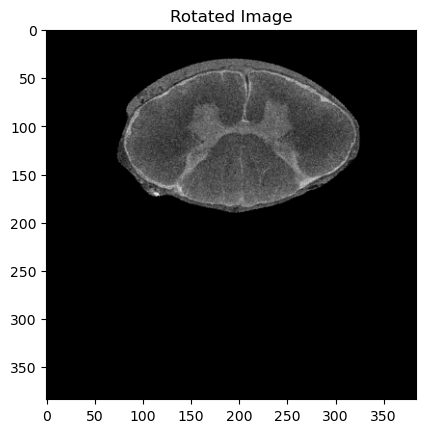

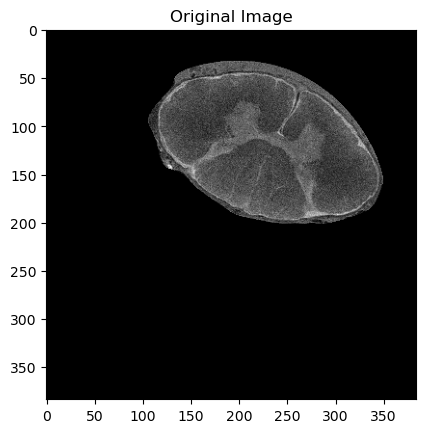

In [129]:
z= 100
plt.imshow(RARE_combined_masked_rotated[:, :, z], cmap='gray')
plt.title('Rotated Image')
plt.show()

plt.imshow(RARE_combined_masked[:, :, z], cmap='gray')
plt.title('Original Image')
plt.show()


In [130]:
# Initialize an empty array to store the rotated images
DTI_combined_masked_rotated = np.zeros_like(DTI_combined)

# Loop through all slices in the z-axis
for z in range(DTI_combined.shape[2]):
    for bvec in range(DTI_combined.shape[3]): 
        DTI_combined_masked_rotated[:, :, z,bvec] = rotate_image(DTI_combined[:, :, z, bvec], complete_lines_array["smoothed_angle"][z])

# Save the rotated images as a 3D NIfTI image
save_nifti("C:/DTI_SC/humanSC_400h/Combined_Data/Rotated and Transposed/DTI_combined_preproc_trans_masked_rotated.nii.gz", DTI_combined_masked_rotated, DTI_Affine_all)

# Validate the rotation

In [ ]:
RARE_combined_masked, RARE_affine_all = load_nifti("Combined_Data/Transposed/RARE_combined_trans_masked.nii.gz")
RARE_rotated_combined_masked, RARE_affine_all = load_nifti("Combined_Data/Rotated and Transposed/RARE_combined_trans_masked_rotated.nii.gz")

rotation_data = np.load("C:/DTI_SC/humanSC_400h/Combined_Data/coordinates_of_lines_for_rotation.pkl", allow_pickle=True)

In [ ]:
image = RARE_combined_masked[:, :, 100]
image_uint8 = ((image - np.min(image)) / (np.max(image) - np.min(image)) * 255).astype(np.uint8)

# Resize for better visibility
image_resized = cv2.resize(image_uint8, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)

# Intensity Correction

## Structural Intensity Correction

In [12]:

RARE_rotated_combined_masked = ants.image_read(("Combined_Data/Rotated and Transposed/RARE_combined_trans_masked_rotated.nii.gz"))

RARE_corrected, bias_field  = ants.n4_bias_field_correction(RARE_rotated_combined_masked, return_bias_field= True)

# Save the corrected image
ants.image_write(RARE_corrected, "C:/DTI_SC/humanSC_400h/Combined_Data/Rotated and Transposed/RARE_combined_trans_masked_rotated_corrected.nii.gz")

ValueError: too many values to unpack (expected 2)

In [ ]:
RARE_rotated_combined_masked = ants.image_read(("Combined_Data/Rotated and Transposed/RARE_combined_trans_masked_rotated.nii.gz"))

RARE_corrected = ants.n4_bias_field_correction(
    image=RARE_rotated_combined_masked,
    #mask=cord_mask,  # optional
    shrink_factor=2,
    convergence= {'iters': [100, 100, 50, 30], 'tol': 1e-6},
    spline_param= 200,
    return_bias_field=True,
    verbose=True
)


#### Compute mean intensity along z (slice axis) ####
original_data = RARE_rotated_combined_masked.numpy()
corrected_data = RARE_corrected.numpy()

mean_intensity_before = original_data.mean(axis=(0,1))
mean_intensity_after = corrected_data.mean(axis=(0,1))

plt.plot(mean_intensity_before, label='Before', linestyle='--')
plt.plot(mean_intensity_after, label='After', linestyle='-')
plt.xlabel('Slice (z-axis)')
plt.ylabel('Mean Intensity')
plt.legend()
plt.title('Intensity Profile Across Slices')
plt.grid()

# Add vertical lines every 70th slice
for x in range(0, len(mean_intensity_before), 70):
    plt.axvline(x=x, color='r', linestyle=':', alpha=0.5)

plt.show()



# Coefficient of variation (CV) across slices

cv_before = np.std(mean_intensity_before) / np.mean(mean_intensity_before)
cv_after = np.std(mean_intensity_after) / np.mean(mean_intensity_after)
print(f"CV before: {cv_before:.4f}, CV after: {cv_after:.4f}")


# Histogram of intensities before and after correction
# Flatten and remove zeros
original_flat = original_data[original_data > 0].flatten()
corrected_flat = corrected_data[corrected_data > 0].flatten()


plt.hist(original_flat, bins=100, alpha=0.5, label='Before')
plt.hist(corrected_flat, bins=100, alpha=0.5, label='After')
plt.legend()
plt.title("Histogram of Intensities")
plt.show()

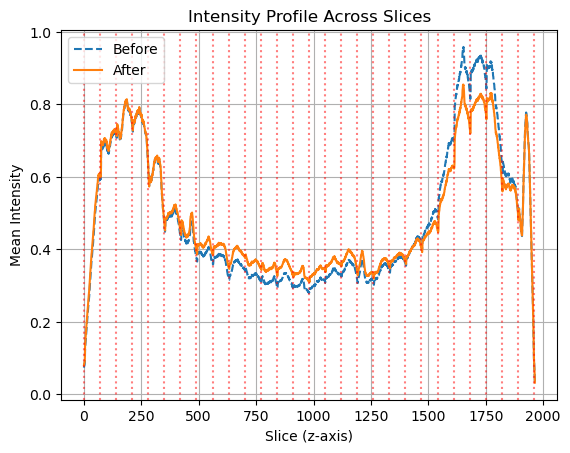

CV before: 0.4002, CV after: 0.3371


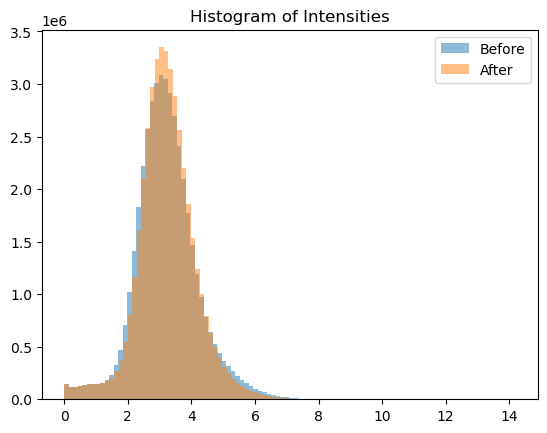

## DTI Intensity Correction

In [3]:
# Load 4D DWI

DTI_combined, DTI_Affine_all = load_nifti("C:/DTI_SC/humanSC_400h/Combined_Data/Rotated and Transposed/DTI_combined_preproc_trans_masked_rotated.nii.gz")


# Select the b=0 volume (commonly first one, or average several b=0 volumes)
b0 = DTI_combined[:,:,:, 0]
b0_ants = ants.from_numpy(b0)


# Run N4 bias correction on b=0
b0_corrected = ants.n4_bias_field_correction(b0_ants)

# Estimate bias field (original / corrected)
bias_field = b0 / (b0_corrected.numpy() + 1e-8)



# Apply the same bias field to all volumes
bias_field_4d = bias_field[..., np.newaxis]
corrected_data = DTI_combined / (bias_field_4d + 1e-8)

# Save the corrected 4D DWI data
save_nifti("C:/DTI_SC/humanSC_400h/Combined_Data/Rotated and Transposed/DTI_combined_preproc_trans_masked_rotated_corrected.nii.gz", corrected_data, DTI_Affine_all)

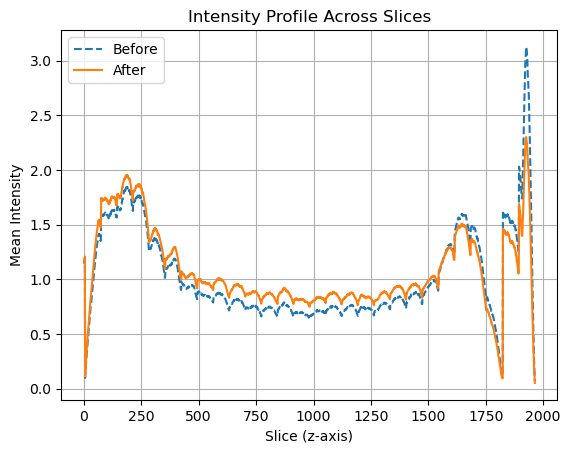

In [4]:
# Compute mean intensity along z (slice axis)
mean_intensity_before = b0.mean(axis=(0,1))
mean_intensity_after = b0_corrected.mean(axis=(0,1))

plt.plot(mean_intensity_before, label='Before', linestyle='--')
plt.plot(mean_intensity_after, label='After', linestyle='-')
plt.xlabel('Slice (z-axis)')
plt.ylabel('Mean Intensity')
plt.legend()
plt.title('Intensity Profile Across Slices')
plt.grid()
plt.show()